/home/mario/anaconda3/envs/computer_vision/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Populating the interactive namespace from numpy and matplotlib
choose target name:
['giant', 'hat_bis', 'rabbit', 'duck', 'test', 'shark', 'train', 'donut', 'teacup', 'hat', 'crow', 'sphere', 'hand', 'helmet', 'dino']
giant
choose styles:
['comics.png', 'orange_aqua.png', 'fragments.png', 'paint_noob.png', 'victor.png', 'dreamy.png']
comics.png


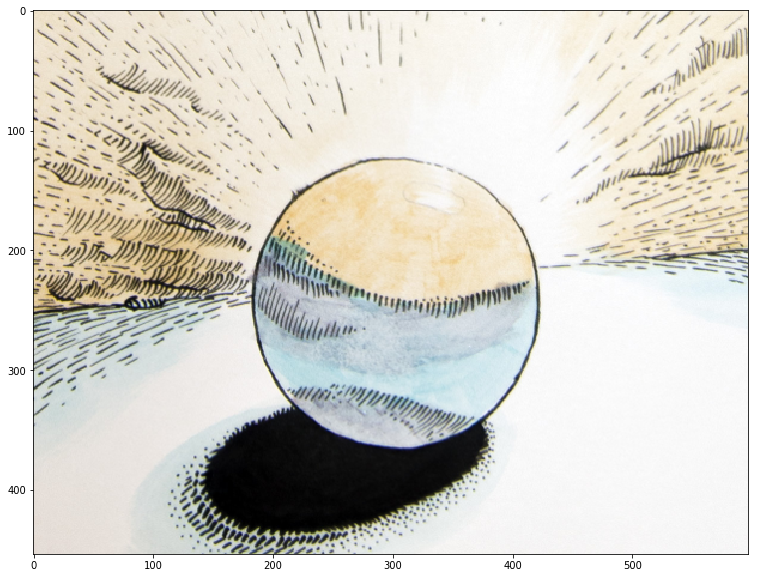

In [1]:
from utils import im_read, show_img, gpyramid, resize_to
import os
import numpy as np
import time
from patchmatch import nnf_approx

seed = int((time.time()*1e6)%1e6)
np.random.seed(seed)

%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

default_files_path = "./files"
target_names = ['giant', 'hat_bis', 'rabbit', 'duck', 'test', 'shark', 'train',
                'donut', 'teacup', 'hat', 'crow', 'sphere', 'hand', 'helmet',
                'dino' ]
source_styles = ['comics.png', 'orange_aqua.png', 'fragments.png',
                 'paint_noob.png', 'victor.png', 'dreamy.png']

lpe_channels = ['lse.png', 'ld12e.png', 'rendered.png', 'lde.png', 'l_dde.png']

def stack_lpe_channels(lpe_channels_path):
    global lpe_channels
    paths = [ os.path.join(lpe_channels_path,lpe_channel) for lpe_channel in lpe_channels ]
    # Take only rgb in any case
    lpe_channels_list = [ im_read(path)[:,:,:3] for path in paths ]
    lpe_stack = lpe_channels_list[0]
    for i in range(1,len(lpe_channels_list)):
        lpe_stack = np.dstack((lpe_stack,lpe_channels_list[i]))
    return lpe_stack

print('choose target name:')
print(target_names)
target = input()

target_path = os.path.join(default_files_path,target_names[target_names.index(target)])
B_lpe = stack_lpe_channels(target_path)

sphere_index = 11
source_path = os.path.join(default_files_path,target_names[sphere_index])
A_lpe = stack_lpe_channels(source_path)

# crop to fit
B_lpe = B_lpe[:A_lpe.shape[0],:A_lpe.shape[1]]

print('choose styles:')
print(source_styles)
s = input()
style_path = os.path.join(source_path,source_styles[source_styles.index(s)])
A_style = im_read(style_path)[:,:,:3]

B_style = np.random.randint(0,high=255,size=A_style.shape, dtype=A_style.dtype)
#B_style = np.zeros(A_style.shape)


A = np.dstack((A_style,A_lpe))
B = np.dstack((B_style,B_lpe))

pyramid_ratio = 2
pyramid_levels = 4

A_gp=gpyramid(A,downscale=pyramid_ratio, max_levels = pyramid_levels )
B_gp=gpyramid(B,downscale=pyramid_ratio, max_levels = pyramid_levels )

show_img(A_style)

#!make

# Patch match for approximated NNF

Simplest approach: use patch match to retrive best matching style image using LPE channels correspondence to compute the NNF (nearest neighbour field).

Populating the interactive namespace from numpy and matplotlib


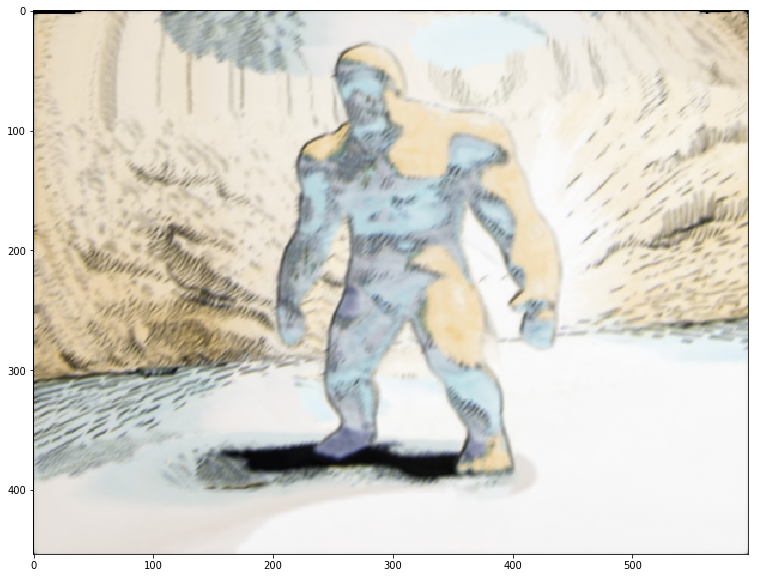

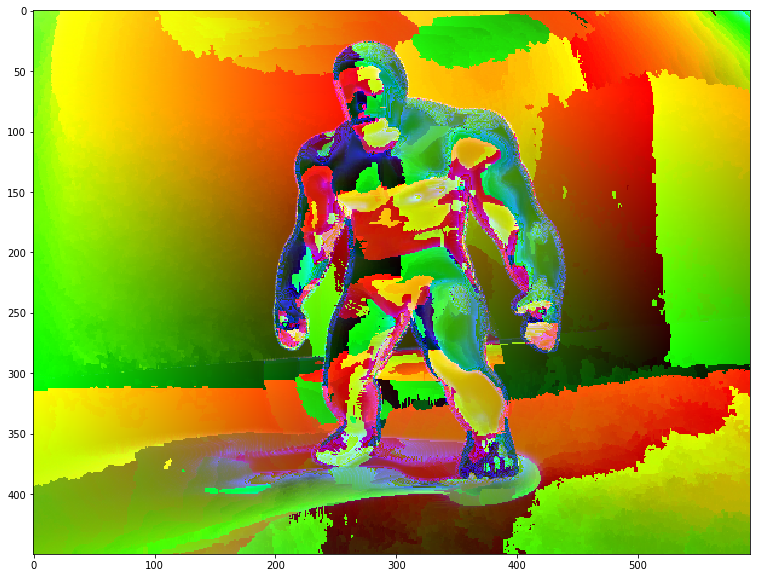

CPU times: user 23.8 s, sys: 667 ms, total: 24.5 s
Wall time: 23.6 s


In [2]:
%%time
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)
from patchmatch import nnf_approx

def nnf_shape(A,B,patch_size):
    h,w = A.shape[0:2]
    h_nnf = h-patch_size//2*2
    w_nnf = w-patch_size//2*2
    return (h_nnf,w_nnf,3)

# first level
l = 0
patch_size = 5
iterations = 5
mu1 = 0.0
mu2 = 1.0
nnf_initialized = False
reconstruct = True
B_gp[l][:,:,:3] = 0
nnf = np.zeros(nnf_shape( B_gp[l], A_gp[l], patch_size ))
rec = nnf_approx( B_gp[l], A_gp[l], nnf, patch_size, iterations, mu1, mu2, nnf_initialized, reconstruct )
B_gp[l][:,:,:3] = rec[:,:,:3]
show_img(rec[:,:,:3])
show_img(nnf)

# Reversed NNF

This method suggest to use the inverse nnf, the target will be reconstructed by searching for all
source patches a best match. Multiple patches in the source will collide on the same best match so once
a match is found the target patch is masked and it will not be assigned anymore.
Therefore inverse NNF retrival must be done again untill all pactches are covered.

This approach however enforces erroneus assignements.

Populating the interactive namespace from numpy and matplotlib


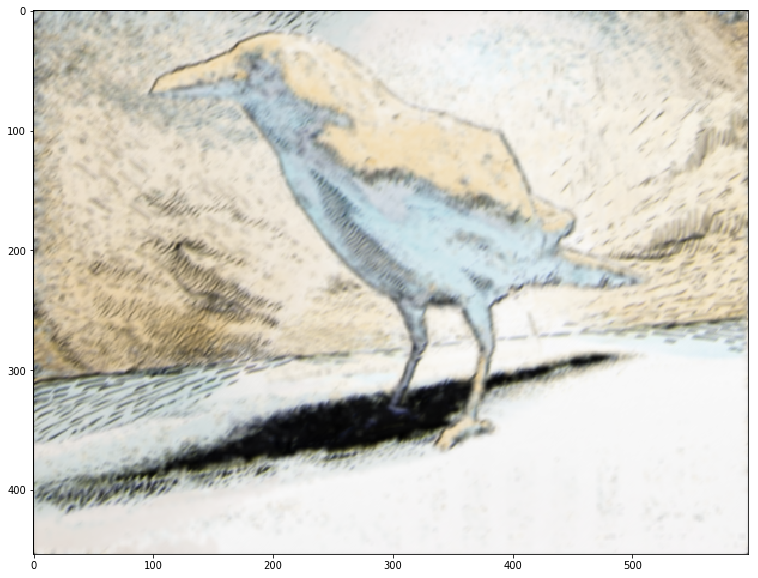

CPU times: user 55.3 s, sys: 376 ms, total: 55.7 s
Wall time: 55.1 s


In [4]:
%%time
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)
from patchmatch_reversed import reversed_nnf_approx, reconstruction
from uniform_patchmatch import uniform

l = 0
patch_size = 5
A = A_gp[l]
B = B_gp[l]
w_map,inv_nnf,real_nnf,maks_B = uniform(A,B,patch_size,mu1=0.0)
rec = reconstruction(B,A,real_nnf,patch_size)
show_img(rec[:,:,:3])

Populating the interactive namespace from numpy and matplotlib


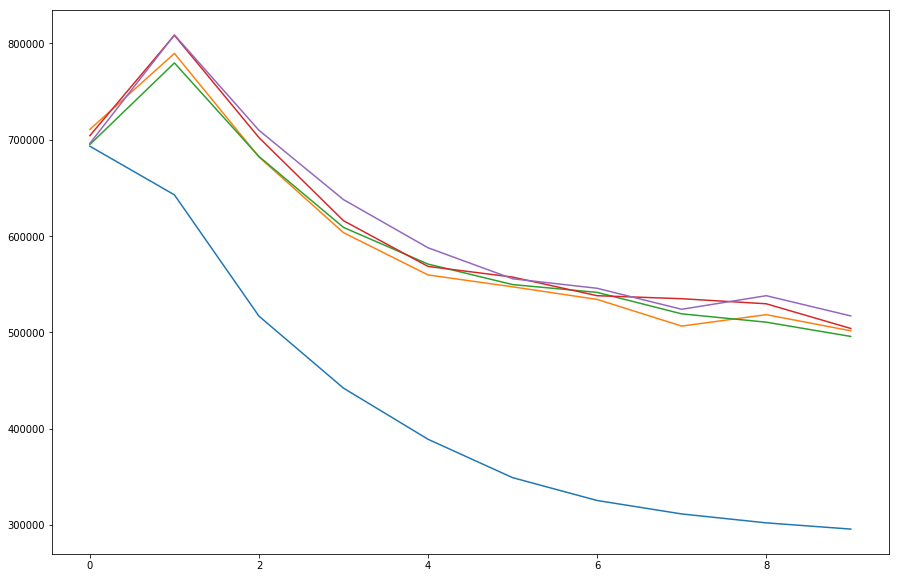

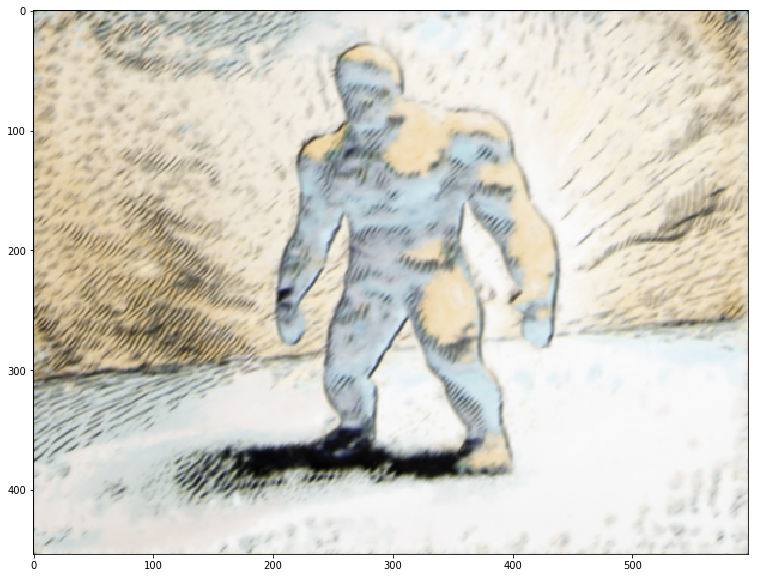

CPU times: user 10min 11s, sys: 1.16 s, total: 10min 12s
Wall time: 10min 11s


In [2]:
%%time
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

from patchmatch_reversed import reversed_nnf_approx, reconstruction
from scipy.optimize import curve_fit as ffit
from uniform_patchmatch import uniform,nnf_shape
import matplotlib.pyplot as plt

def hyperbole(x_data,a,b):
    return numpy.power(a-b*x_data,-1.0)
    
def knee(a,b):
    inv_b = numpy.power(b,-1.0)
    return - (np.sqrt(inv_b)+a*inv_b)

def non_uniform_step_approx(A,B,mask_B,inv_nnf,real_nnf,w_map):
    mean = np.mean(w_map[w_map>0.0])
    stdev = np.std(w_map[w_map>0.0])
    error_max = mean+(3)*stdev
    h,w = inv_nnf.shape[:2]
    for i in range(h):
        for j in range(w):
            nnf_i,nnf_j =int(inv_nnf[i,j,0]),int(inv_nnf[i,j,1])
            if w_map[nnf_i,nnf_j] > error_max:
                # de mask patches
                real_nnf[nnf_i,nnf_j] = 0.0,0.0,-1.0
                mask_B[nnf_i,nnf_j] = 1.0
    return mask_B

def non_uniform_step(A,B,mask_B,inv_nnf,real_nnf,w_map):
    """
        this function threats the non uniform cases by setting free patches with an error above
        the knee point of the hyperbole fitted to the sorted error.
    """
    y_data = np.sort(w_map[w_map>0.0].flatten())
    x_data = np.array(range(y_data.shape[0]))[::-1]*(-1.0)
    popt, pcov = ffit(hyperbole,x_data,y_data,maxfev=10000)
    k = knee(*popt)
    error_max = hyperbole(k,*popt)
    if not np.isnan(k):
        h,w = inv_nnf.shape[:2]
        for i in range(h):
            for j in range(w):
                nnf_i,nnf_j =int(inv_nnf[i,j,0]),int(inv_nnf[i,j,1])
                if w_map[nnf_i,nnf_j] > error_max:
                    # de mask patches
                    real_nnf[nnf_i,nnf_j,0] = 0.0
                    real_nnf[nnf_i,nnf_j,1] = 0.0
                    real_nnf[nnf_i,nnf_j,2] = -1.0
                    mask_B[nnf_i,nnf_j] = 1.0
    return mask_B


def non_uniform(A,B,patch_size,nnf_iterations=5,mu1=1.0,mu2=2.0,approx_non_unif=True):
    mask_B = np.ones(nnf_shape(B,A,patch_size)[:2])
    real_nnf = np.zeros(nnf_shape(B,A,patch_size))
    inv_nnf = np.zeros(nnf_shape(A,B,patch_size))
    max_num_patch = float(np.sum(mask_B))
    done = False
    maxiter,i = 10,0
    global_error = []
    while not done and i<maxiter:
        w_map,inv_nnf,real_nnf,mask_B = uniform( A,B,patch_size,
                                                 real_nnf = real_nnf,
                                                 inv_nnf = inv_nnf,
                                                 mask_B = mask_B, 
                                                 mu1 = mu1, mu2 = mu2,
                                                 nnf_iterations = nnf_iterations,
                                                 compesate_via_nnf=True)
        w_map = real_nnf[:,:,2]
        if approx_non_unif:
            mask_B = non_uniform_step_approx(A,B,mask_B,inv_nnf,real_nnf,w_map)      
        else:
            mask_B = non_uniform_step(A,B,mask_B,inv_nnf,real_nnf,w_map)    
        # check for convergence
        global_error+= [np.sum(w_map[w_map>0.0])]
        percent = np.sum(mask_B)/max_num_patch
        done = percent < 0.0001
        i+=1
    plt.plot(global_error)
    return w_map,inv_nnf,real_nnf

l = 0
patch_size = 5
A = A_gp[l]
B = B_gp[l]
for i in range(2):
    w_map,inv_nnf,real_nnf = non_uniform(A,B,patch_size,mu1=0.0)
    rec = reconstruction(B,A,real_nnf,patch_size)
    B[:,:,:3] = rec[:,:,:3]
show_img(rec[:,:,:3])


# Multiscale

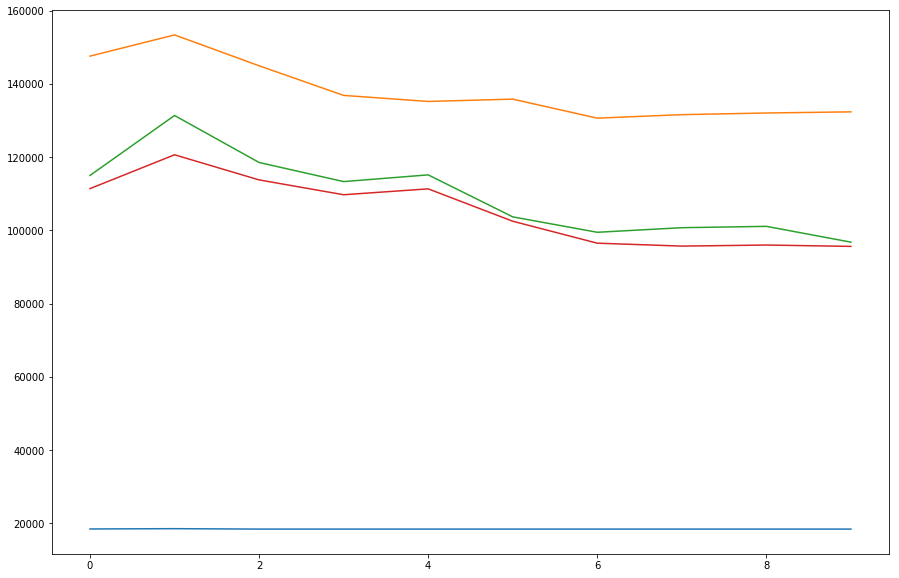

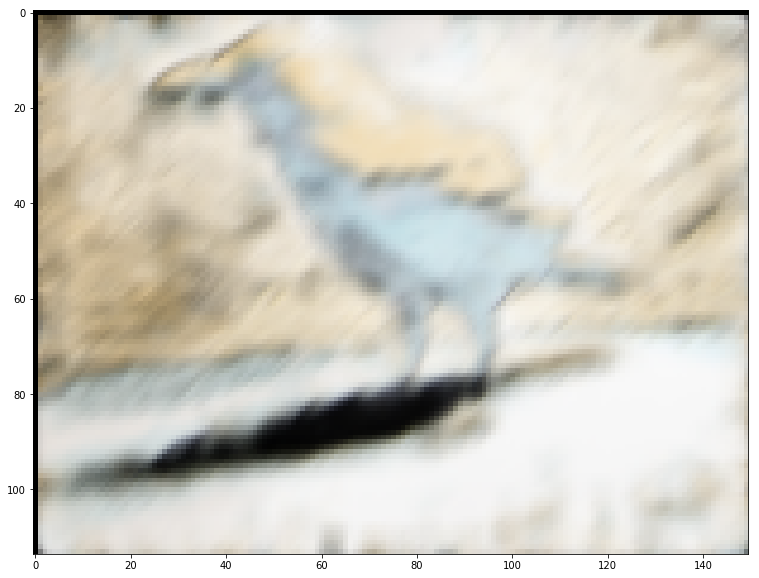

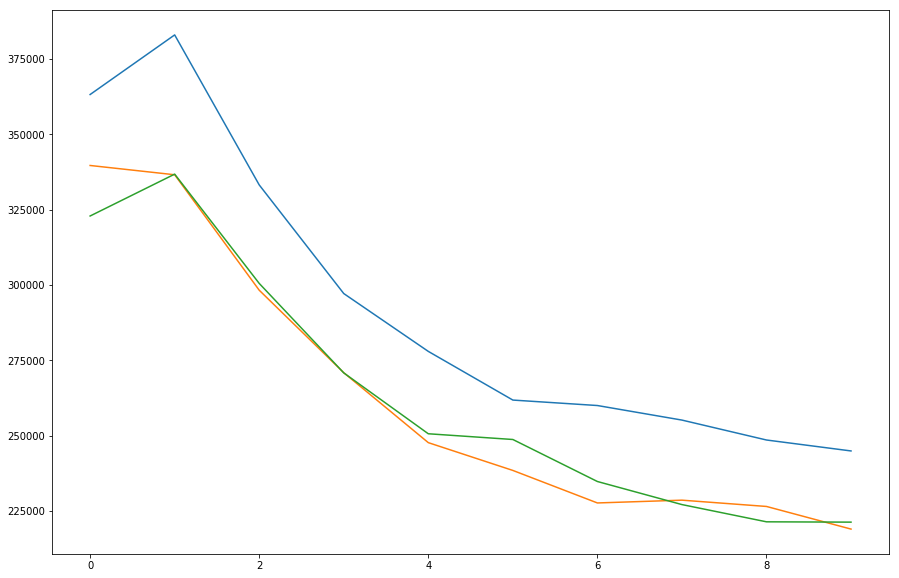

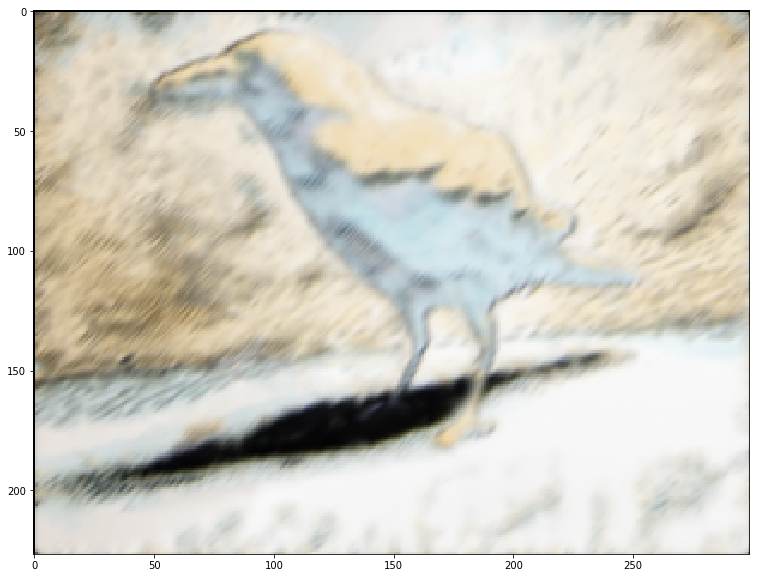

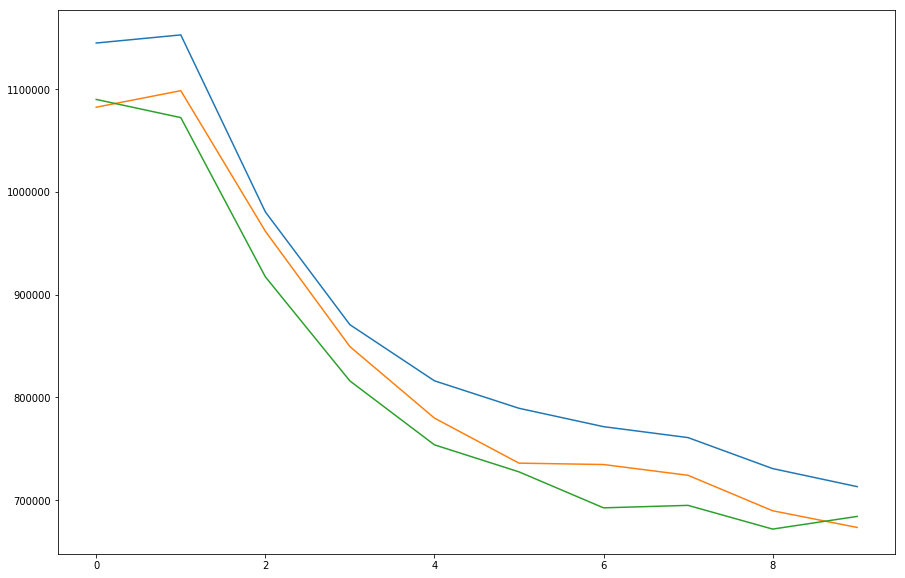

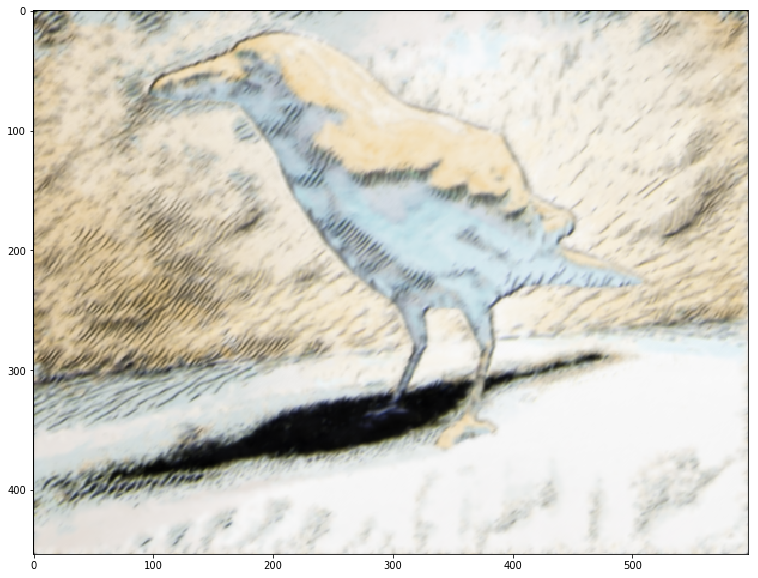

In [27]:
l = 4
patch_size = 5
A = A_gp[l]
B = B_gp[l]
w_map,inv_nnf,real_nnf = non_uniform(A,B,patch_size,mu1=0.0)
rec = reconstruction(B,A,real_nnf,patch_size)

for i in range(len(B_gp)-3,-1,-1):
    # next level
    A = A_gp[i]
    B = B_gp[i]
    h1,w1,c= B.shape
    rec_next = resize_to(rec,[h1,w1,c])
    B[:,:,:3] = rec_next[:,:,:3]
    w_map,inv_nnf,real_nnf = non_uniform(A,B,patch_size)
    rec = reconstruction(B,A,real_nnf,patch_size)
    B[:,:,:3] = rec[:,:,:3]
    w_map,inv_nnf,real_nnf = non_uniform(A,B,patch_size)
    rec = reconstruction(B,A,real_nnf,patch_size)
    B[:,:,:3] = rec[:,:,:3]
    w_map,inv_nnf,real_nnf = non_uniform(A,B,patch_size)
    show_img(rec[:,:,:3])
